## Событийная аналитика мобильного приложения по продаже продуктов

Необходимо исследовать поведение пользователей мобильного приложения по продаже продуктов питания и выяснить, сколько пользователей и как доходят до покупки, на каком этапе воронки есть проседание трафику, а так же проанализировать результаты A/A1/B теста по 3 группам: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. В нашем распоряжении есть записи логов с информацией о действиях пользователей, или событиях:
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

    
 

### План

1. [Открыть файл и изучить общую информацию, выявить проблемы в данных](#start)
2. [Предобработка данных:](#preparing_data)
    - [Заменить названия столбцов;](#changing_column_name)
    - [Проверить пропуски и типы данных;](#check_data)
    - [Добавить столбец даты и времени, и отдельный столбец дат;](#add_columns)
3. [Изучить и проверить данные:](#logs_analysis)
    - [Выяснить сколько всего событий в логе;](#count_event)
    - [Выяснить сколько всего пользователей в логе;](#count_users)
    - [Выяснить сколько в среднем событий приходится на пользователя;](#average_event_by_user)
    - [Найти максимальную и минимальную дату. Построить гистограмму по дате и времени.  Определить, с какого момента данные полные и отбросить более старые.](#check_period)
4. [Изучить воронку событий](#funnel_analysis)
    - [Найти уникальные события и отсортировать их по частоте;](#check_unique_event)
    - [Посчитать, сколько пользователей совершали каждое из этих событий. Отсортировать события по числу пользователей. Посчитать долю пользователей, которые хоть раз совершали событие;](#number_of_user_by_event)
    - [Выяснить все ли события выстраиваются в последовательную цепочку;](#funnel_event_order)
    - [Посчитать по воронке событий , какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем);](#count_percent_from_previous)
    - [Выяснить на каком шаге теряете больше всего пользователей](#check_churn)
    - [Найти какая доля пользователей доходит от первого события до оплаты](#count_cr)
5. [Изучите результаты эксперимента](#test_analysis)
    - [Посчитать, сколько пользователей в каждой экспериментальной группе](#count_users_per_test_group)
    - [Проверить, находят ли статистические критерии разницу между выборками 246 и 247(А и А1)](#stat_differance_between_246_247)
    - [Посчитать число пользователей, совершивших самое популярное событие в каждой из контрольных групп. Посчитать долю пользователей, совершивших это событие. Проверить, будет ли отличие между группами статистически достоверным. Рассчитать предыдушие шаги для всех других событий. Выяснить, корректно ли разбиты группы](#check_stat_differance_between_group_by_event)
    - [Аналогично проделать предыдушие шаги с группой с изменённым шрифтом(B). Сравнить результаты с каждой из контрольных групп в отдельности по каждому событию. Сравнить результаты с объединённой контрольной группой](#check_stat_differance_between_group_by_event)
    
6. [Общий вывод](#conclusion)
    
    
    

<a id="start"></a>
### Шаг 1. Откройте файл с данными и изучите общую информацию



In [35]:
#read file
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

data_startup = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
data_startup.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Загруженный датасет состоит 4 столбцов. В первом столбце (EventName) находятся ключевые пользовательские события, во втором столбце (DeviceIDHash) - уникальный идентификатор, присвоенный пользователю при обращении к приложению, столбец (EventTimestamp) с временем конкретного события и столбец (ExpId) с разметкой пользователей по контрольным групам A/A1/B теста. Уже можно заметить, что столбец EventTimestamp необходимо перевести в формат даты. Также все названия столбцов записаны в верхнем регистре, далее мы поменяем его на нижний для удобства в дальнейшей работе с данными.

<a id="preparing_data"></a>
### Шаг 2. Подготовьте данные


<a id="changing_column_name"></a>
Заменим названия столбцов на удобные для нас, а также проверим пропуски и типы данных. 

In [36]:
# rename columns
data_startup.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

<a id="check_data"></a>
Проверим пропуски и типы данных

In [37]:
# check type of data
data_startup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name         244126 non-null object
device_id_hash     244126 non-null int64
event_timestamp    244126 non-null int64
exp_id             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Датасет состоит из 244126 строк и 4 столбцов. Столбцу event_timestamp присвоен тип данных int64, однако мы знаем, что по условию в даннм столбце содержится информация о дате события, поэтому далее заменим тип данных на datetime

In [38]:
# check missing values
data_startup.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

Методом isna().sum() выяснили, что в даннных нет пропусков. 

<a id="add_columns"></a>
Переведем данные в столбце event_timestamp в формат даты и добавим столбец даты и времени, а также отдельный столбец дат

In [39]:
# convert event_timestamp to datatime and date
data_startup['datetime'] = data_startup.event_timestamp.astype("datetime64[s]")
data_startup['date'] = data_startup.datetime.dt.date
data_startup

,event_name,device_id_hash,event_timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Проверим данные на наличие дубликатов:

In [40]:
data_startup.duplicated().sum()

413

Так как дублированные строки повторяют друг друга в точности до секунд в столбце datetime, можно предположить, что пользователь обновлял приложение и событие могло сработать повторно. Доля дубликатов в общем датасете занимает менее 1%, поэтому мы можем их удалить 

In [41]:
data_startup.drop_duplicates(inplace = True )

### Вывод

На данном шаге мы изучили загруженный датасет методом head() и info(). Привели данные к корректным типам: столбец event_timestamp к типу данных datetime; выяснили, что в данных нет пропущенных значений; перевели названия столбцов в нижний регистр и добавили дополнительные столбцы с датой и временем и датой для удобства дальнейшего анализа.Проверили данные на наличие дубликатов и удалили их методом drop_duplicates()

<a id="logs_analysis"></a>
### Шаг 3. Изучите и проверьте данные


<a id="count_event"></a>
Выясним, сколько всего событий в датасете:

In [42]:
total_events = data_startup.event_name.count()
print('Total events number: {}'.format(total_events))

Total events number: 243713


<a id="count_users"></a>
Также найдем количество уникальных пользователей в логах:

In [43]:
# count users in logs

user_number = data_startup.device_id_hash.nunique()
print('Number of unique users: {}'.format(user_number))

Number of unique users: 7551


<a id="average_event_by_user"></a>
Далее рассчитаем сколько в среднем событий приходится на пользователя:

Average events count by users: 32.27559263673685
Median events count by users: 20.0


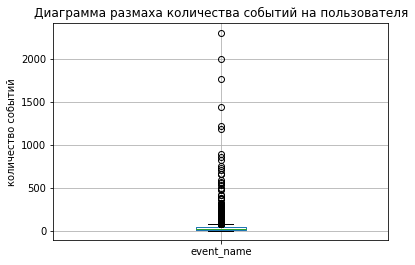

In [44]:
#count average event per user  

average_event_by_user = data_startup.groupby('device_id_hash').agg({'event_name':'count'}).mean()[0]
median_event_by_user = data_startup.groupby('device_id_hash').agg({'event_name':'count'}).median()[0]
print('Average events count by users: {}'.format(average_event_by_user))
print('Median events count by users: {}'.format(median_event_by_user))
#data_startup.groupby('device_id_hash').agg({'event_name':'count'}).hist(bins=100)
plt.title("Диаграмма размаха количества событий на пользователя")
plt.ylabel("количество событий")
data_startup.groupby('device_id_hash').agg({'event_name':'count'}).boxplot()

Среднее количество событий на пользователя выше чем медиана, следовательно, можем сделать вывод, что датасет скошен вправо. На графике boxplot видно, что в данных присутствуют выбросы по аномально высоким значениям количества событий на пользователя

<a id="check_period"></a>
При наличии 5 уникальных событий пользователи в среднем совершают 32 события, чтобы понять совершают ли пользователи все события повторно (всю воронку), а также понять частоту этих событий, изучим период данных которым мы располагаем:

In [45]:
# check min and max data
minimum_date = data_startup.date.min()
maximum_date = data_startup.date.max()
print('Minimum date: {}\nMaximum data: {}'.format(minimum_date, maximum_date))

Minimum date: 2019-07-25
Maximum data: 2019-08-07


Мы имеем данные за 2 недели, построим гистограмму, чтобы выяснить как распределены данные за весь период:

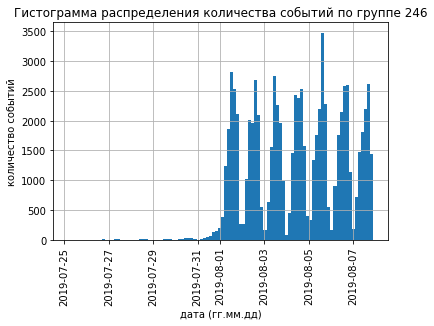

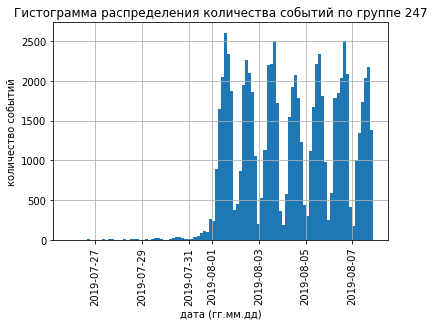

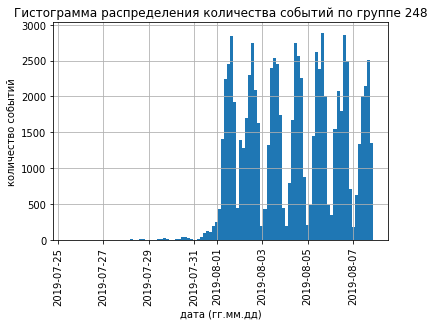

In [46]:
#built hist by date
grouped_data = data_startup.groupby(['event_name', 'datetime','exp_id']).count().reset_index()
plt.title("Гистограмма распределения количества событий по группе 246")
plt.xlabel("дата (гг.мм.дд)")
plt.ylabel("количество событий")
plt.xticks(rotation=90)
grouped_data[grouped_data.exp_id == 246].datetime.hist(bins = 100)
plt.show()
plt.title("Гистограмма распределения количества событий по группе 247")
plt.xlabel("дата (гг.мм.дд)")
plt.ylabel("количество событий")
plt.xticks(rotation=90)
grouped_data[grouped_data.exp_id == 247].datetime.hist(bins = 100)
plt.show()
plt.title("Гистограмма распределения количества событий по группе 248")
plt.xlabel("дата (гг.мм.дд)")
plt.ylabel("количество событий")
plt.xticks(rotation=90)
grouped_data[grouped_data.exp_id == 248].datetime.hist(bins = 100)
plt.show()


Данные гистограммы свидетельствуют о том, что данные по 3 тестируемым группам (A/A1/B) стали накапливаться с 31 июля. Поэтому мы отбросим данные до 1 августа и далее будем анализировать датасет в разрезе периода 1.08.2019-7.08.2019.  Фактически теперь мы располагаем данными за 1 неделю (что недостаточно для остановки и выводов по тесту).

In [47]:
# we choose 1st August as starting point of our experiment
actual_data = data_startup[data_startup.datetime >= '2019-08-01']

Выясним, какое количество пользователей мы потеряли, отбросив старые данные 

In [48]:
#check persentage of removing data
old_data = data_startup[data_startup.datetime < '2019-08-01']
removed_users = old_data.device_id_hash.nunique()
print('Number of users we remove: {}'.format(removed_users))


Number of users we remove: 1451


В данных по пользователям мы потеряли 1451 уник, однако можно предположить, что эти пользователи возвращались в приложение уже в актуальных для нас период. Проверим нашу гипотезу методом intersection:

In [49]:
intersection_old_actual = len(set(old_data.device_id_hash.unique()).intersection(set(actual_data.device_id_hash.unique())))
intersection_old_actual

1434

Как мы видим 1434 уника находятся обьединены по двум датасетам, то есть 1434 уника из старых данных есть и в нашем актуальном датасете. Найдем количество пользователей, которых мы удалили из датасета, и которые не вернулись в приложение в актуальный период:

In [50]:
actual_removed_users = removed_users- intersection_old_actual
print('Number of actual removed users: {}'.format(actual_removed_users))

Number of actual removed users: 17


Найдем, сколько событий мы потеряли, отбросив старые данные:

In [51]:
removed_events = old_data.event_name.value_counts().sum()
total_events = data_startup.event_name.value_counts().sum()
print('Number of event we remove: {}'.format(removed_events))
print('Percentage of events we remove: {:.0%}'.format(removed_events / total_events))

Number of event we remove: 2826
Percentage of events we remove: 1%


Отбросив старые данные мы потеряли 17 пользователей, что составляет менее 1% от общего количества пользователей, и 2826 событий, что составляет 1% от всех событий

Проверим, остались ли пользователи за по актуальный период во всех 3 группах:

In [52]:
actual_users_count = actual_data.groupby('exp_id').agg({'device_id_hash':'nunique'})
actual_users_count.columns = ['number_of_users']
actual_users_count

,number_of_users
exp_id,
246,2484
247,2513
248,2537


### Вывод

В данном шаге мы разобрались с количественными значениями по нашим ключевым метрикам: узнали, что в нашем датасете 7551 уникальных пользователя и 243713 событий, также рассчитали, что среднее количество событий на пользователя (~32) и извлекли актуальный срез данных по датасету (с 1 по 7 августа 2019). Далее изучим более детально воронку по ключевым событиям пользователей

<a id="funnel_analysis"></a>
### Шаг 4. Изучите воронку событий


<a id="check_unique_event"></a>
Посмотрим, какие события есть в логах и как часто они встречаются:

In [53]:
#extract unique events
actual_data.event_name.value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

<a id="funnel_event_order"></a>

Наиболее частотное событие MainScreenAppear, можем предположить, что как только пользователь заходит в приложение он видит главный экран, далее идет событие с предложениями товаров OffersScreenAppear, далее переход в корзину CartScreenAppear, и, наконец, событие с оплатой PaymentScreenSuccessful. Tutorial можно рассматрививать не в контексте воронки , так как это обучающие материалы по приложению, в случае возникновения трудностей с юзабилити приложения

<a id="number_of_user_by_event"></a>
Посчитаем, сколько пользователей совершали каждое из этих событий, а также посчитаем долю пользователей, которые хоть раз совершали событие.

In [54]:
#count number of users by event
event_funnel_by_user = actual_data.groupby('event_name').agg({'device_id_hash':'nunique'}).sort_values(by='device_id_hash', ascending=False)
event_funnel_by_user

,device_id_hash
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [55]:
#count total users and count share by each event 
total_actual_user = actual_data.device_id_hash.nunique()
event_funnel_by_user['percentage'] = event_funnel_by_user.device_id_hash / total_actual_user
event_funnel_by_user

,device_id_hash,percentage
event_name,,
MainScreenAppear,7419,0.984736
OffersScreenAppear,4593,0.609636
CartScreenAppear,3734,0.495620
PaymentScreenSuccessful,3539,0.469737
Tutorial,840,0.111495


Как мы видим 98% видели главный экран и около 2% по каким-либо причинам запустили приложение, но не воспользовались им. 60% процентов пользователей дошли до события с предложениями товаров, почти 50% пользователей дошло до оформления корзины и 46% до оплаты

<a id="count_percent_from_previous"></a>

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки от числа пользователей на предыдущем, предварительно исключив из последовательности воронки событие Tutorial.

In [56]:
#remove tutorial from funnel
#count share from previous event
event_funnel_by_user = event_funnel_by_user.reset_index()
event_funnel_by_user = event_funnel_by_user[event_funnel_by_user.event_name != 'Tutorial']
event_funnel_by_user['percent_from_previous'] = event_funnel_by_user.device_id_hash / event_funnel_by_user.device_id_hash.shift(1)
event_funnel_by_user

,event_name,device_id_hash,percentage,percent_from_previous
0,MainScreenAppear,7419,0.984736,NaN
1,OffersScreenAppear,4593,0.609636,0.619086
2,CartScreenAppear,3734,0.495620,0.812976
3,PaymentScreenSuccessful,3539,0.469737,0.947777


<a id="check_churn"></a>

Как мы видим на шаге 1 - после главного экрана переход на предложения по продуктам, теряется около 40% пользователей, причиной могут быть проблемы с юзабилити или в визуальном оформлении интерфейса

<a id="count_cr"></a>
Посчитаем, какая доля пользователей доходит от первого события до оплаты, то есть до конечного целевого действия

In [57]:
#count share of users who achieved payment from first event  
convertion_rate = event_funnel_by_user.loc[3,'device_id_hash'] / event_funnel_by_user.loc[0,'device_id_hash']
print('Convertion rate: {:.1%}'.format(convertion_rate))

Convertion rate: 47.7%


Чуть меньше 50% пользователей совершили покупку в приложении от всех пользователей, вошедших в приложение.

### Вывод

В данном шаге мы исследовали пути пользователей по ключевым событиям. Нам удалось выяснить, что основная воронка событий состоит из просмотра главного экрана, затем пользователи переходят на экран с предложениями продуктов, далее переходят в корзину, оформляют и оплачивают заказ. Помимо этого в приложении есть гайд (туториал) по юзабилити приложения, однако им воспользовались только 11% пользователей. Основной отток(~40%) происходит при переходе пользователей с главного экрана на экран с предложениями товаров, причиной могут быть проблемы с юзабилити или в целом в визуальном оформлении интерфейса. Далее изучим данные по тестовым группам и выясним повлияли ли изменения в дизайне шрифтов на поведение пользователей

<a id="test_analysis"></a>
### Шаг 5. Изучите результаты эксперимента

<a id="count_users_per_test_group"></a>
Найдем количество пользователей в каждой контрольной группе:

In [58]:
# count number of users by each group
users_in_group = actual_data.groupby('exp_id').agg({'device_id_hash':'nunique'})
users_in_group

,device_id_hash
exp_id,
246,2484
247,2513
248,2537


In [59]:
#extract each group in separate table 
users_246_group = actual_data[actual_data.exp_id == 246]
users_247_group = actual_data[actual_data.exp_id == 247]
users_248_group = actual_data[actual_data.exp_id == 248]

<a id="stat_differance_between_246_247"></a>

Пользователи распределены равномерно по трем группам.Однако прежде чем анализировать A/B тест, проверим выборки A и A1 на статистическую разницу в данных. Для этого узнаем соответсвуют ли выборки следующим критериям:
 - Количество пользователей в различных группах различается не более, чем на 1%;
 - Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости;
 - Попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [60]:
# check differance between group
count_user_246 = users_246_group.device_id_hash.nunique()
count_user_247 = users_247_group.device_id_hash.nunique()

difference = abs(count_user_246 - count_user_247) / (count_user_246 + count_user_247) / 2
print('Difference percentage between group 246 and group 247: {:.1%}'.format(difference))

Difference percentage between group 246 and group 247: 0.3%


Статистическая разница в пределах нормы: количество пользователей в по двух контрольным группам различается не более, чем на 1%


Проверим, через метод intersection, что попавший в одну из групп посетитель остаётся в этой группе до конца теста.

In [61]:
intersection = len(set(users_246_group.device_id_hash.unique()).intersection(set(users_247_group.device_id_hash.unique())))
print('Common user count between group 246 and group 247: {}'.format(intersection))

Common user count between group 246 and group 247: 0


Пользователей, которые входят в обе группы 0, следовательно можем сделать вывод, что пользователи не пересекаются по двум группам

Проверим, являются ли данные по двум контрольным группам A и A1 по самому популярному событию - MainScreenAppear статистически достоверными.

In [62]:
count_key_metric_246 = len(users_246_group[users_246_group.event_name =='MainScreenAppear'])
count_key_metric_247 = len(users_247_group[users_247_group.event_name =='MainScreenAppear'])

difference = abs(count_key_metric_246 - count_key_metric_247) / (count_key_metric_246 + count_key_metric_247) / 2
print('Difference percentage between group 246 and group 247 in key metric: {:.1%}'.format(difference))

Difference percentage between group 246 and group 247 in key metric: 0.9%


Различие ключевых метрик по группам не превышает 1% 

<a id="check_stat_differance_between_group_by_event"></a>
Напишем функцию, с помощью которой будем рассчитывать долю пользователей совершивших каждое событие по всем событиям воронки и проверять наличие статистической разницы между группами. Для сравнения доли пользователей совершивших событие от общего количества пользователей по группам будем использовать z тест. В качестве альфы примем общепринятое пороговое значение — 5%

In [63]:
def calculate_statistical_difference(event_name, group1, group2):
    key_event_users_1 = group1[group1.event_name == event_name]
    key_event_users_2 = group2[group2.event_name == event_name]
    key_metric_user_count_1 = key_event_users_1.device_id_hash.nunique()
    key_metric_user_count_2 = key_event_users_2.device_id_hash.nunique()
    total_users_1 = group1.device_id_hash.nunique()
    total_users_2 = group2.device_id_hash.nunique()
    alpha = .05 # критический уровень статистической значимости

    successes = np.array([key_metric_user_count_1, key_metric_user_count_2])
    trials = np.array([total_users_1, total_users_2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")



Проверим гипотезу по каждому уникальному событию: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful - о том, что доля пользователей, совершивших событие (от всех пользователей) в приложении по группе A, равна доле пользователей совершивших аналогичное событие по контрольной группе A1.

Нулевая гипотеза: Доля пользователей, совершивших событие в группе 246, не отличается от доли пользователей совершивших аналогичное событие в группе 247 (нет статистической значимой разницы).

Альтернативная гипотеза H₁: Доля пользователей, cовершивших событие в группе 246, отличается от доли пользователей совершивших аналогичное событие в группе 247 (есть статистически значимая разница)

In [64]:
calculate_statistical_difference('MainScreenAppear', users_246_group, users_247_group)
calculate_statistical_difference('OffersScreenAppear', users_246_group, users_247_group)
calculate_statistical_difference('CartScreenAppear', users_246_group, users_247_group)
calculate_statistical_difference('PaymentScreenSuccessful', users_246_group, users_247_group)

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Мы видим, по контрольным группам A и A1 по всем событиям нет разницы в долях, т.е мы можем считать, что в выборках статистически значимого различия нет

Проверим гипотезу по каждому уникальному событию: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful - о том, что доля пользователей, совершивших событие (от всех пользователей) в приложении по группе A, равна доле пользователей совершивших аналогичное событие по контрольной группе B.

Нулевая гипотеза: Доля пользователей, совершивших событие в группе 246, не отличается от доли пользователей совершивших аналогичное событие в группе 248 (нет статистической значимой разницы).

Альтернативная гипотеза H₁: Доля пользователей, cовершивших событие в группе 246, отличается от доли пользователей совершивших аналогичное событие в группе 248 (есть статистически значимая разница)

In [65]:
calculate_statistical_difference('MainScreenAppear', users_246_group, users_248_group)
calculate_statistical_difference('OffersScreenAppear', users_246_group, users_248_group)
calculate_statistical_difference('CartScreenAppear', users_246_group, users_248_group)
calculate_statistical_difference('PaymentScreenSuccessful', users_246_group, users_248_group)

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверим гипотезу по каждому уникальному событию: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful - о том, что доля пользователей, совершивших событие (от всех пользователей) в приложении по группе A1, равна доле пользователей совершивших аналогичное событие по контрольной группе B.

Нулевая гипотеза: Доля пользователей, совершивших событие в группе 247, не отличается от доли пользователей совершивших аналогичное событие в группе 248 (нет статистической значимой разницы).

Альтернативная гипотеза H₁: Доля пользователей, cовершивших событие в группе 247, отличается от доли пользователей совершивших аналогичное событие в группе 248 (есть статистически значимая разница)

In [66]:
calculate_statistical_difference('MainScreenAppear', users_247_group, users_248_group)
calculate_statistical_difference('OffersScreenAppear', users_247_group, users_248_group)
calculate_statistical_difference('CartScreenAppear', users_247_group, users_248_group)
calculate_statistical_difference('PaymentScreenSuccessful', users_247_group, users_248_group) 

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнение по контрольным группам A и A1 c B показало, что статистически значимых различий между группами по всем событиям воронки нет однако анализируемые данные затрагивают только недельный период

Проверим гипотезу по каждому уникальному событию: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful - о том, что доля пользователей, совершивших событие (от всех пользователей) в приложении в объединенной контрольной группе (A и A1), равна доле пользователей совершивших аналогичное событие по контрольной группе B.

Нулевая гипотеза: Доля пользователей, совершивших событие в объединенной группе (246 и 247), не отличается от доли пользователей совершивших аналогичное событие в группе 248 (нет статистической значимой разницы).

Альтернативная гипотеза H₁: Доля пользователей, cовершивших событие в объединенной группе (246 и 247), отличается от доли пользователей совершивших аналогичное событие в группе 248 (есть статистически значимая разница))

In [67]:
merge_control_group = actual_data[actual_data.exp_id != 248]

In [68]:
calculate_statistical_difference('MainScreenAppear', merge_control_group, users_248_group)
calculate_statistical_difference('OffersScreenAppear', merge_control_group, users_248_group)
calculate_statistical_difference('CartScreenAppear', merge_control_group, users_248_group)
calculate_statistical_difference('PaymentScreenSuccessful', merge_control_group, users_248_group) 

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Объединенные данные по контрольным группам  A и A1 в сравнении с контрольной группой B также не показали статистической значимой разницы в долях пользователей по каждому событию от общего количества пользователей. 

Суммарно было проведено 16 проверок статистических гипотез: 4 гипотезы о равенстве долей по каждому событию между двумя контрольными группами A и A1; 4 гипотезы о равенстве долей по каждому событию между двумя группами A и B; 4 гипотезы о равенстве долей по каждому событию между двумя группами A1 и B; и 4 гипотезы о равенстве долей по каждому событию между объединенной группой (A и A1) и B.

<a id="conclusion"></a>
## Вывод

Перед нами стояла задача проанализировать поведение пользователей в приложении по продаже продуктов питания и выяснить сколько пользователей и  как доходят до покупки, на каком этапе воронки есть проседание трафику, а так же проанализировать результаты A/A1/B теста по 3 группам: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

На первом этапе мы подготовили данные для анализа: привели данные к нужному типу,добавили дополнительные столбцы с датой и временем и датой для удобства в дальнейшем анализу. Проверили данные на наличие пропусков

Второй этап состоял из исследования количественных данных в логах:мы выяснили, что датасет содержит 5 уникальных событий, всего приложение посетили 7551 пользователь, средняя частота событий на пользователя составила 32. Далее, чтобы сделать более детальные выводы по полученным количественным данным, мы изучили период, за который взяты логи. Период составил две недели, однако при более детальном рассмотрении мы выяснили, что данные по трем группам стали накапливаться со второй недели. Поэтому мы приняли решение отсечь старую дату и взять только актуальные данные (с 1.08.2019 - 7.08.2019). По отсеченной дате мы выяснили, что потеряли около 1% по событиям и менее 1% пользователей, так как большинство пользователей повторно возвращались на сайт. Среднее количество событий на пользователя может свидетельствовать о том, что пользовтаели повторно возвращаются на сайт и совершают ключевые события или в рамках одной сессии пользоввтель совершает повторно несколько событий(несколько раз просматривает страницу с предложениями, возвращается в начало воронки)

В следующем пункте мы изучили воронку событий. Выяснили, что самым частотным событием является просмотр главного экрана, далее идет экран с предложением продуктов, затем переход в корзину и оплата товара. Кроме того мы выяснили, что больше всего пользователей уходит между шагом 1 и 2(переход от главного экрана до экрана с предложениями продуктов), возможно, причины кроются в сложностях с юзабилити сайта или визуально сложном интерфейсе. Также мы выяснили, что от первого события до целевого(оплата продуктов) доходит 47% пользователей
Дополнительно в нашем распоряжении, помимо основной воронки, были данные по событию туториал, мы выяснили, что только 11% пользователей переходит на него.

Последний пункт состоял из анализа результатов A/B теста. Мы выяснили, что группы равномерно распределены по количеству пользователей. Далее мы сравнили 2 группы 246 и 247 (А и А1) на наличие статистической разницы. Полученные данные показали, что различие ключевых метрик по группам не превышает 1% и статистическая разница в пределах нормы: количество пользователей в по двух контрольным группам различается не более, чем на 1%. Далее мы проанализировали 2 контрольные группы на наличие статистической разницы по каждому событию и не выявили статистически значимой разницы в долях.Для проверки гипотез о равенстве долей использовали z-тест. В качестве альфы взяли общепринятое пороговое значение — 5%. Сравнив попарно группы A /B и A1/B, мы пришли к выводу, что между долями нет статистически значимой разницы. Также объединив данные по контрольным группам A и A1 и сравнив их с группой B, мы выяснили, что данные статистически не различаются,то есть новый шрифт не повлиял на поведение пользователей.
